In [1]:
import os
import json
import time
import logging
from copy import deepcopy
from dotenv import load_dotenv
import nest_asyncio
from typing import Optional

import os
import fitz  # PyMuPDF

from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient

from llama_index.core import StorageContext, VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.schema import TextNode, ImageNode, NodeWithScore, MetadataMode
from llama_index.core.settings import Settings
from llama_index.core.query_engine import CustomQueryEngine, SimpleMultiModalQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.vector_stores.azureaisearch import AzureAISearchVectorStore, IndexManagement, MetadataIndexFieldType
import os
import asyncio
from azure.storage.blob.aio import BlobServiceClient
from dotenv import load_dotenv
from llama_parse import LlamaParse
import re
from copy import deepcopy
from typing import Dict, List
from llama_index.core.schema import TextNode, MetadataMode
import nest_asyncio
from llama_index.multi_modal_llms.azure_openai import AzureOpenAIMultiModal
# Example usage of MultimodalQueryEngine
from llama_index.core.response.notebook_utils import display_response, display_query_and_multimodal_response, display_source_node
from llama_index.core.schema import MetadataMode
from llama_index.core.vector_stores.types import VectorStoreQueryMode

load_dotenv()

# Apply nest_asyncio to avoid asyncio errors in notebooks
nest_asyncio.apply()

### Set variables

In [ ]:
# Environment Variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME")
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME")
SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
SEARCH_SERVICE_API_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")
BLOB_CONNECTION_STRING = os.getenv("BLOB_CONNECTION_STRING")
BLOB_STORAGE_ACCOUNT_KEY = os.getenv("BLOB_STORAGE_ACCOUNT_KEY")

INDEX_NAME = "llamaindex-azure-aisearch-rag"
BLOB_CONTAINER_NAME = "multimodal"

# Limit the number of concurrent uploads
CONCURRENT_UPLOADS = 1

# Configuración del documento local
EXAMPLE_DOCUMENTS_PATH = "example_documents/"
DOCUMENT_EXAMPLE_NAME = f"{EXAMPLE_DOCUMENTS_PATH}requisitos legales CONSTRUCCION feb2024 ESTATAL 3.pdf"

# Configuración de directorios
DOWNLOAD_PATH = "data_images"

API_VERSION= "2024-08-01-preview"

### Initialize services

In [2]:

# Initialize LLM and Embedding models
llm = AzureOpenAI(
    engine=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=API_VERSION
)

embed_model = AzureOpenAIEmbedding(
    engine=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=API_VERSION
)

Settings.llm = llm
Settings.embed_model = embed_model

# Initialize search clients
credential = AzureKeyCredential(SEARCH_SERVICE_API_KEY)
index_client = SearchIndexClient(endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential)
search_client = SearchClient(endpoint=SEARCH_SERVICE_ENDPOINT, index_name=INDEX_NAME, credential=credential)

### Document Processing and Image Extraction

In [7]:
# Obtener el nombre base del documento sin extensión y limpiar espacios
document_base_name = os.path.splitext(os.path.basename(DOCUMENT_EXAMPLE_NAME))[0]
document_base_name = document_base_name.replace(" ", "_")  # Reemplazar espacios por guiones bajos

os.makedirs(DOWNLOAD_PATH, exist_ok=True)

# Procesar el PDF con PyMuPDF
doc = fitz.open(DOCUMENT_EXAMPLE_NAME)
md_json_list = []
image_dicts = []

for page_num, page in enumerate(doc):
    page_text = page.get_text("text")
    
    # Construir el nombre de la imagen con el nombre del documento original
    image_filename = f"{DOWNLOAD_PATH}/{document_base_name}_page_{page_num + 1}.png"
    pix = page.get_pixmap()
    pix.save(image_filename)
    
    md_json_list.append({
        "page": page_num + 1,
        "md": page_text if page_text.strip() else "",  # Se asegura que siempre haya 'md'
    })
    image_dicts.append({"page": page_num + 1, "image_path": image_filename, "name": os.path.basename(image_filename), "original_file_path": image_filename})

if not md_json_list:
    raise ValueError("Error: No se ha extraído texto del PDF. Revisa el documento o la configuración.")

print(md_json_list)
print(image_dicts)


[{'page': 1, 'md': 'IDENTIFICACIÓN Y EVALUACIÓN DE REQUISITOS LEGALES\n(Informe Excel Modelo B)\nListado de Requisitos generado por \nohl el 16/02/2024\nTotal Requisitos (según los criterios de selección aplicados al generar el \ninforme): 581\nNorma / Art. / Aspecto / Referencia\nRequisito (Título, descripción, observaciones, responsable, lugar de \narchivo...)\nCUMPLE\nNO CUMPLE\nNO APLICA \nEN PROCESO DE \nCUMPLIMIENTO\nOBSERVACIONES\nESTATAL - Real Decreto 487/2022, \npor el que se establecen los requisitos sanitarios para la \nprevención y el control de la legionelosis\nArtículo 5.4\nLegionelosis\nDeber del titular de la instalación de describir y acreditar \ndocumentalmente las tareas contratadas con un servicio externo.\nEn caso de que la persona titular de la instalación contrate con un servicio \nexterno la realización total o parcial de las tareas descritas en el presente \nreal decreto, éstas deberán quedar descritas y acreditadas \ndocumentalmente.\nESTATAL - Real Decreto 4

### Asynchronous Image Upload to Azure Blob Storage


In [8]:
async def create_container_if_not_exists(connection_string: str, container_name: str):
    """Create container if it doesn't exist, handling the operation once."""
    blob_service_client = BlobServiceClient.from_connection_string(connection_string)
    async with blob_service_client:
        container_client = blob_service_client.get_container_client(container_name)
        if not await container_client.exists():
            try:
                await container_client.create_container()
                print(f"Container {container_name} created successfully")
            except Exception as e:
                print(f"Error creating container: {e}")

async def upload_image_to_blob_storage(image, blob_name, semaphore):
    """Upload a single image to blob storage."""
    async with semaphore:
        try:
            image_path = image.get('path') or image.get('original_file_path')
            if not image_path or not os.path.exists(image_path):
                print(f"Image path not found or invalid: {image_path}")
                return None

            blob_service_client = BlobServiceClient.from_connection_string(BLOB_CONNECTION_STRING)
            async with blob_service_client:
                container_client = blob_service_client.get_container_client(BLOB_CONTAINER_NAME)
                blob_client = container_client.get_blob_client(blob_name)

                with open(image_path, "rb") as f:
                    await blob_client.upload_blob(f, overwrite=True)
                    print(f"Successfully uploaded {blob_name}")
                return blob_client.url

        except Exception as e:
            print(f"Failed to upload {blob_name}: {str(e)}")
            return None

async def main():
    """Main function to handle container creation and image uploads."""
    # First, ensure the container exists
    await create_container_if_not_exists(BLOB_CONNECTION_STRING, BLOB_CONTAINER_NAME)
    
    # Then proceed with uploads
    semaphore = asyncio.Semaphore(CONCURRENT_UPLOADS)
    upload_tasks = [upload_image_to_blob_storage(image, image["name"], semaphore) 
                   for image in image_dicts]
    
    results = await asyncio.gather(*upload_tasks)
    
    # Create dictionary of successful uploads
    successful_uploads = {
        image["name"]: url
        for image, url in zip(image_dicts, results)
        if url is not None
    }
    
    # Print summary
    print(f"\nUpload Summary:")
    print(f"Total images: {len(image_dicts)}")
    print(f"Successfully uploaded: {len(successful_uploads)}")
    print(f"Failed uploads: {len(image_dicts) - len(successful_uploads)}")
    
    return successful_uploads

# Run the main function
image_urls = asyncio.run(main())

Successfully uploaded requisitos_legales_CONSTRUCCION_feb2024_ESTATAL_3_page_1.png
Successfully uploaded requisitos_legales_CONSTRUCCION_feb2024_ESTATAL_3_page_2.png
Successfully uploaded requisitos_legales_CONSTRUCCION_feb2024_ESTATAL_3_page_3.png
Successfully uploaded requisitos_legales_CONSTRUCCION_feb2024_ESTATAL_3_page_4.png
Successfully uploaded requisitos_legales_CONSTRUCCION_feb2024_ESTATAL_3_page_5.png
Successfully uploaded requisitos_legales_CONSTRUCCION_feb2024_ESTATAL_3_page_6.png
Successfully uploaded requisitos_legales_CONSTRUCCION_feb2024_ESTATAL_3_page_7.png
Successfully uploaded requisitos_legales_CONSTRUCCION_feb2024_ESTATAL_3_page_8.png
Successfully uploaded requisitos_legales_CONSTRUCCION_feb2024_ESTATAL_3_page_9.png
Successfully uploaded requisitos_legales_CONSTRUCCION_feb2024_ESTATAL_3_page_10.png
Successfully uploaded requisitos_legales_CONSTRUCCION_feb2024_ESTATAL_3_page_11.png
Successfully uploaded requisitos_legales_CONSTRUCCION_feb2024_ESTATAL_3_page_12.png
S

### Text Node Creation


In [9]:
def get_page_number(file_name: str) -> int:
    """Extract page number from blob name."""
    match = re.search(r"page_(\d+)\.jpg$", str(file_name))
    if match:
        return int(match.group(1))
    return 0

def _get_sorted_blob_urls(image_urls: Dict[str, str]) -> List[str]:
    """Get blob URLs sorted by page number."""
    sorted_items = sorted(image_urls.items(), key=lambda x: get_page_number(x[0]))
    return [url for _, url in sorted_items]

def get_text_nodes(image_urls: Dict[str, str], json_dicts: List[dict]) -> List[TextNode]:
    """Create TextNodes with metadata including blob URLs as image_path."""
    nodes = []
    
    sorted_urls = _get_sorted_blob_urls(image_urls)
    md_texts = [d["md"] for d in json_dicts]

    for idx, md_text in enumerate(md_texts):
        if idx >= len(sorted_urls):
            continue
            
        node = TextNode(
            text=md_text,
            metadata={
                "page_num": idx + 1,
                "image_path": sorted_urls[idx],
                "parsed_text_markdown": md_texts[idx],
            }
        )
        nodes.append(node)

    return nodes

# Create text nodes
text_nodes = get_text_nodes(image_urls=image_urls, json_dicts=md_json_list)

# Print an example node to verify
print(text_nodes[0].get_content(metadata_mode=MetadataMode.ALL))

page_num: 1
image_path: https://ecoembesstg.blob.core.windows.net/multimodal/requisitos_legales_CONSTRUCCION_feb2024_ESTATAL_3_page_1.png
parsed_text_markdown: IDENTIFICACIÓN Y EVALUACIÓN DE REQUISITOS LEGALES
(Informe Excel Modelo B)
Listado de Requisitos generado por 
ohl el 16/02/2024
Total Requisitos (según los criterios de selección aplicados al generar el 
informe): 581
Norma / Art. / Aspecto / Referencia
Requisito (Título, descripción, observaciones, responsable, lugar de 
archivo...)
CUMPLE
NO CUMPLE
NO APLICA 
EN PROCESO DE 
CUMPLIMIENTO
OBSERVACIONES
ESTATAL - Real Decreto 487/2022, 
por el que se establecen los requisitos sanitarios para la 
prevención y el control de la legionelosis
Artículo 5.4
Legionelosis
Deber del titular de la instalación de describir y acreditar 
documentalmente las tareas contratadas con un servicio externo.
En caso de que la persona titular de la instalación contrate con un servicio 
externo la realización total o parcial de las tareas descritas en 

### Vector Store Integration


In [10]:
# Define metadata fields mapping
metadata_fields = {
    "page_num": ("page_num", MetadataIndexFieldType.INT64),
    "image_path": ("image_path", MetadataIndexFieldType.STRING),
    "parsed_text_markdown": ("parsed_text_markdown", MetadataIndexFieldType.STRING),
}

def create_vector_store(
    index_client,
    index_name: str,
    use_existing_index: bool = False
) -> AzureAISearchVectorStore:
    """Create or get existing Azure AI Search vector store."""
    return AzureAISearchVectorStore(
        search_or_index_client=index_client,
        index_name=index_name,
        index_management=IndexManagement.VALIDATE_INDEX if use_existing_index 
                        else IndexManagement.CREATE_IF_NOT_EXISTS,
        id_field_key="id",
        chunk_field_key="parsed_text_markdown",
        embedding_field_key="embedding",
        embedding_dimensionality=3072,
        metadata_string_field_key="metadata",
        doc_id_field_key="doc_id",
        filterable_metadata_field_keys=metadata_fields,
        language_analyzer="en.lucene",
        vector_algorithm_type="exhaustiveKnn",
        semantic_configuration_name="mySemanticConfig"
    )

def create_or_load_index(
    text_nodes,
    index_client,
    index_name: str,
    embed_model,
    llm,
    use_existing_index: bool = False
) -> VectorStoreIndex:
    """Create new index or load existing one."""
    vector_store = create_vector_store(index_client, index_name, use_existing_index)
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    
    if use_existing_index:
        return VectorStoreIndex.from_documents(
            [],
            storage_context=storage_context,
        )
    else:
        return VectorStoreIndex(
            nodes=text_nodes,
            storage_context=storage_context,
            embed_model=embed_model,
            llm=llm,
            show_progress=True,
        )

# Initialize vector store index
index = create_or_load_index(
    text_nodes=text_nodes,
    index_client=index_client,
    index_name=INDEX_NAME,
    embed_model=embed_model,
    llm=llm,
    use_existing_index=False
)

async_search_or_index_client is None. Depending on the client type passed in, sync or async functions may not work.
Generating embeddings: 100%|██████████| 111/111 [03:08<00:00,  1.70s/it]


### Custom Multmodal Query Engine

In [3]:
# Define QA prompt template
QA_PROMPT_TMPL = """\
Below we give parsed text from slides in parsed markdown format, as well as the image.

---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query. Explain whether you got the answer
from the parsed markdown or raw text or image, and if there's discrepancies, and your reasoning for the final answer.

Query: {query_str}
Answer: """

QA_PROMPT = PromptTemplate(QA_PROMPT_TMPL)


class MultimodalQueryEngine(CustomQueryEngine):
    """Custom multimodal Query Engine for public blob storage."""

    qa_prompt: PromptTemplate
    retriever: BaseRetriever
    multi_modal_llm: AzureOpenAIMultiModal

    def __init__(self, qa_prompt: Optional[PromptTemplate] = None, **kwargs) -> None:
        """Initialize."""
        super().__init__(qa_prompt=qa_prompt or QA_PROMPT, **kwargs)

    def custom_query(self, query_str: str) -> Response:
        # Retrieve relevant nodes
        nodes = self.retriever.retrieve(query_str)

        # Create ImageNode items directly using the blob URLs
        image_nodes = []
        for n in nodes:
            if "image_path" in n.metadata:
                try:
                    image_nodes.append(
                        NodeWithScore(
                            node=ImageNode(image_url=n.metadata["image_path"])
                        )
                    )
                except Exception as e:
                    print(
                        f"Warning: Failed to create ImageNode for {n.metadata['image_path']}: {str(e)}"
                    )
                    continue

        # Create context string from text nodes
        context_str = "\n\n".join(
            [node.get_content(metadata_mode=MetadataMode.LLM) for node in nodes]
        )

        # Format the prompt
        fmt_prompt = self.qa_prompt.format(context_str=context_str, query_str=query_str)
        # Get response from multimodal LLM
        llm_response = self.multi_modal_llm.complete(
            prompt=fmt_prompt,
            image_documents=[image_node.node for image_node in image_nodes],
        )

        return Response(
            response=str(llm_response),
            source_nodes=nodes,
            metadata={"text_nodes": nodes, "image_nodes": image_nodes},
        )


# Initialize GPT-4o multimodal model
azure_openai_mm_llm = AzureOpenAIMultiModal(
    engine=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_version="2024-08-01-preview",
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    max_new_tokens=4096,
    api_key=AZURE_OPENAI_API_KEY,
    api_base=AZURE_OPENAI_ENDPOINT,
)

# Create and initialize the query engine
query_engine = MultimodalQueryEngine(
    retriever=index.as_retriever(
        vector_store_query_mode=VectorStoreQueryMode.DEFAULT, similarity_top_k=5 # default is pure vector search, try HYBRID or SEMANTIC_HYBRID
    ),
    multi_modal_llm=azure_openai_mm_llm,
)

NameError: name 'index' is not defined

### Testing the System

Query: Quien debe realizar la prueba de funcionamiento de todos los pulsadores de los dispositivos para la activación manual de alarma de protección contra incendio
Retrieved Images:



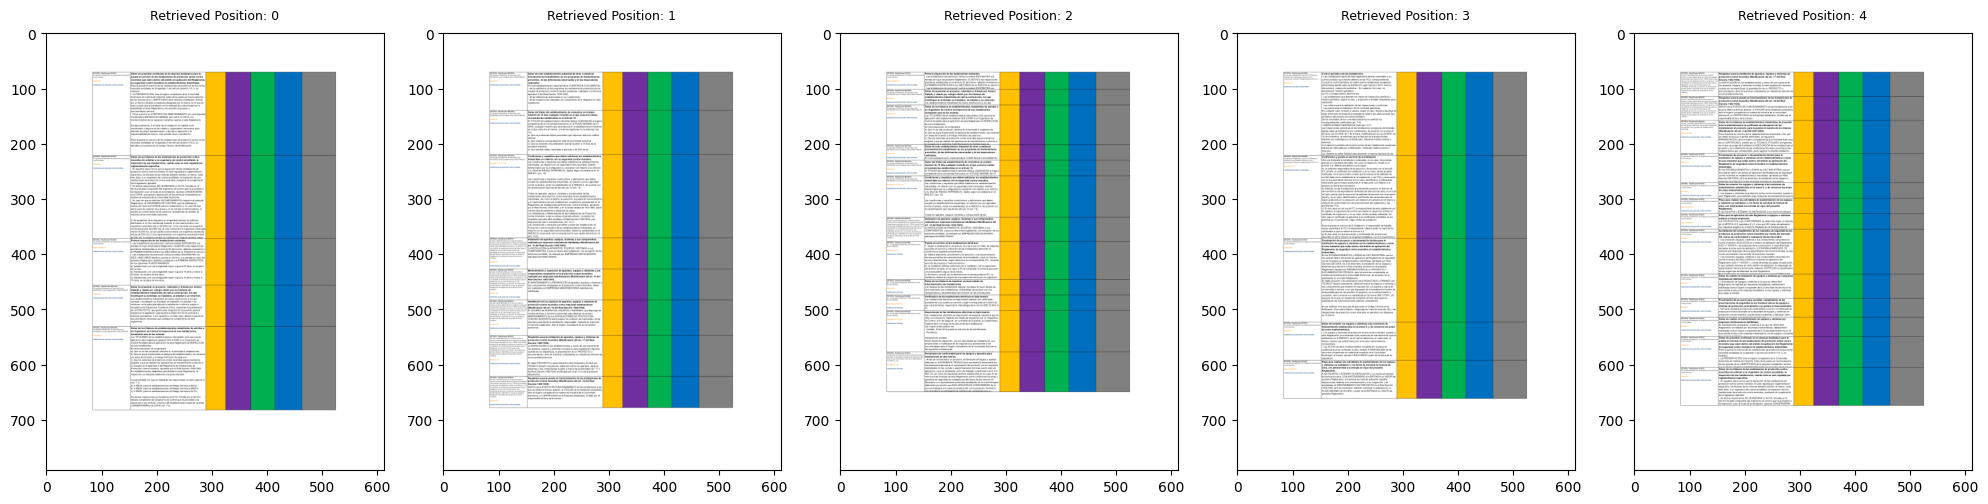

Response: La prueba de funcionamiento de todos los pulsadores de los dispositivos para la activación manual de alarma de protección contra incendio debe ser realizada por empresas mantenedoras habilitadas. Esta información se obtiene del texto que menciona que el mantenimiento de equipos y sistemas de protección contra incendios se realizará por empresas mantenedoras debidamente habilitadas ante el órgano competente de la Comunidad Autónoma.

Esta respuesta se basa en el contenido del texto proporcionado en el parsed_text_markdown, específicamente en las secciones que detallan las responsabilidades de las empresas mantenedoras en el mantenimiento de los sistemas de protección contra incendios. No hay discrepancias entre el parsed_text_markdown y la imagen proporcionada.


Source Nodes:

Page Number: 83
Text Content Length: 7434

Page Number: 84
Text Content Length: 9226

Page Number: 28
Text Content Length: 8897

Page Number: 81
Text Content Length: 7522

Page Number: 27
Text Content L

In [14]:
# Example query focused on visual and textual content
query = "Quien debe realizar la prueba de funcionamiento de todos los pulsadores de los dispositivos para la activación manual de alarma de protección contra incendio"

# Execute the query
response = query_engine.query(query)

# Display the query and multimodal response
display_query_and_multimodal_response(query, response, 8, 20)

# Print source nodes for transparency
print("\nSource Nodes:")
for node in response.source_nodes:
    print("\nPage Number:", node.metadata["page_num"])
    print("Text Content Length:", len(node.text))

Query: ¿qué formación debe tener un trabajador designado como recurso preventivo?
Retrieved Images:



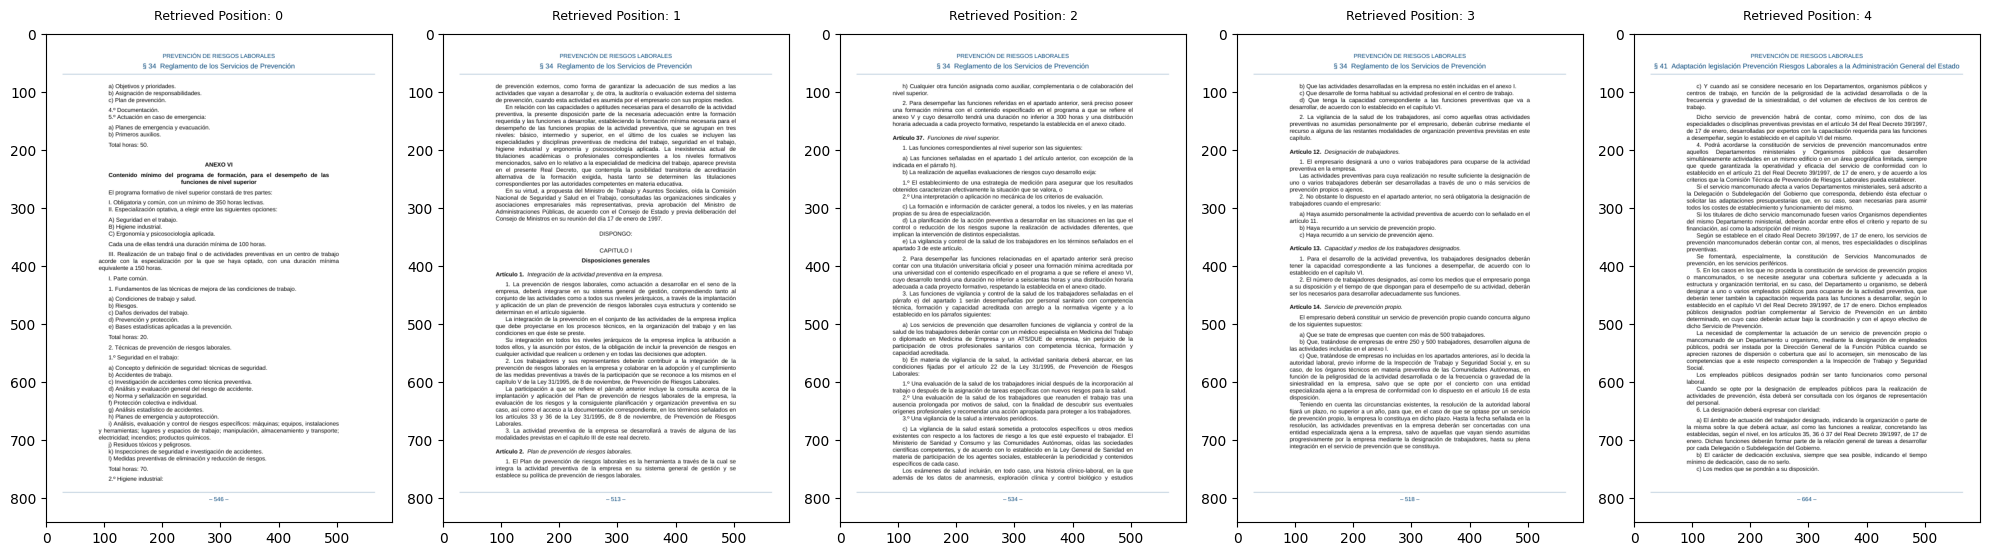

Response: Para desempeñar las funciones de un trabajador designado como recurso preventivo, es necesario que posea la capacidad correspondiente a las funciones preventivas que va a desarrollar, de acuerdo con lo establecido en el capítulo VI del Real Decreto 39/1997, de 17 de enero. Esto incluye tener la formación mínima especificada en el programa correspondiente, que puede variar según el nivel de funciones (básico, intermedio o superior).

La información se obtuvo de la imagen de la página 540, que detalla los requisitos de capacidad y medios de los trabajadores designados, así como de la página 556, que especifica las funciones y la formación requerida para los niveles superiores. No hay discrepancias entre el texto parseado y las imágenes proporcionadas.


Source Nodes:

Page Number: 568
Text Content Length: 2082

Page Number: 535
Text Content Length: 4035

Page Number: 556
Text Content Length: 4021

Page Number: 540
Text Content Length: 3390

Page Number: 686
Text Content Length:

In [27]:
# Example query focused on visual and textual content
query = "¿qué formación debe tener un trabajador designado como recurso preventivo?"

# Execute the query
response = query_engine.query(query)

# Display the query and multimodal response
display_query_and_multimodal_response(query, response, 8, 20)

# Print source nodes for transparency
print("\nSource Nodes:")
for node in response.source_nodes:
    print("\nPage Number:", node.metadata["page_num"])
    print("Text Content Length:", len(node.text))